In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/abhishek/Documents/Spring22/CS7641/cs7641-project/dataset/Stanford/Split-Images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

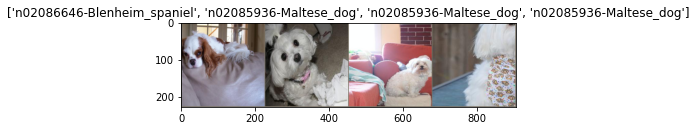

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    print(outputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            print(outputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [26]:
def visualize_model_new(model, num_images=6):
    # was_training = model.training
    model.eval()
    images_so_far = 0
    print(num_images)
    # fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            print(outputs.shape)
            print(inputs.size())
            # _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                print(images_so_far)
                # ax = plt.subplot(num_images//2, 2, images_so_far)
                # ax.axis('off')
                # ax.set_title(f'predicted: {class_names[preds[j]]}')
                # imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    # model.train(mode=was_training)
                    return
        # model.train(mode=was_training)

In [6]:
model_ft = models.resnet18(pretrained=True)
# print(model_ft)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3532 Acc: 0.5032
val Loss: 0.3274 Acc: 0.8923

Epoch 1/24
----------
train Loss: 1.0774 Acc: 0.6448
val Loss: 0.4490 Acc: 0.8615

Epoch 2/24
----------
train Loss: 0.9878 Acc: 0.6620
val Loss: 0.5650 Acc: 0.8538

Epoch 3/24
----------
train Loss: 1.0084 Acc: 0.6524
val Loss: 0.7908 Acc: 0.7923

Epoch 4/24
----------
train Loss: 0.9976 Acc: 0.6738
val Loss: 0.4771 Acc: 0.8231

Epoch 5/24
----------
train Loss: 0.8945 Acc: 0.7006
val Loss: 0.5592 Acc: 0.8077

Epoch 6/24
----------
train Loss: 0.8478 Acc: 0.6985
val Loss: 0.4896 Acc: 0.8462

Epoch 7/24
----------
train Loss: 0.6805 Acc: 0.7736
val Loss: 0.3628 Acc: 0.8923

Epoch 8/24
----------
train Loss: 0.6308 Acc: 0.7961
val Loss: 0.2938 Acc: 0.9154

Epoch 9/24
----------
train Loss: 0.6556 Acc: 0.7940
val Loss: 0.3007 Acc: 0.9231

Epoch 10/24
----------
train Loss: 0.5456 Acc: 0.8294
val Loss: 0.2812 Acc: 0.9231

Epoch 11/24
----------
train Loss: 0.5324 Acc: 0.8197
val Loss: 0.2882 Acc: 0.9308

Ep

tensor([[-1.3690, -1.6327, -0.3911, -0.2351, -1.5735, -4.1746,  6.8445],
        [-2.6167, -1.1978, -0.0094, -0.2858,  0.2323,  5.2839, -2.3788],
        [-3.2658, -1.8563,  0.7293,  1.2005,  4.9293, -2.1860,  0.5066],
        [-1.1651, -1.1558, -2.0631, -1.0634,  0.1908,  6.7223, -3.0033]],
       device='cuda:0')


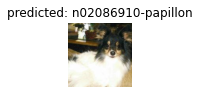

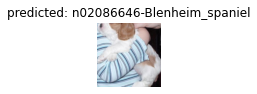

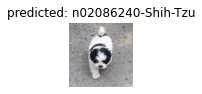

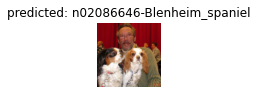

tensor([[-1.8389, -0.5600, -2.5408,  7.2805,  0.4405, -1.0224, -1.3462],
        [ 8.5263, -2.9604,  1.0755, -0.1738, -2.1623, -3.0599, -1.6458],
        [ 0.8603, -5.2663, -0.6829,  4.1045,  5.4032, -0.1554, -3.8674],
        [ 1.3327,  1.0708, -1.2026, -4.8289, -3.8744, -0.5932,  6.7477]],
       device='cuda:0')


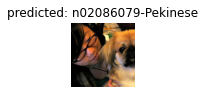

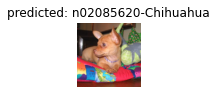

In [15]:
visualize_model(model_ft)

In [27]:
model_new = model_ft
model_new.fc = nn.Identity()
visualize_model_new(model_new)

6
torch.Size([4, 512])
torch.Size([4, 3, 224, 224])
1
2
3
4
torch.Size([4, 512])
torch.Size([4, 3, 224, 224])
5
6


In [32]:
images_all = None
labels_all = None
for images, labels in dataloaders['val']:
    images = images.to(device)
    labels = labels.numpy()
    if labels_all is None:
        labels_all = labels
    else:
        labels_all = np.concatenate((labels_all, labels))
    outputs = model_new(images).detach().cpu().numpy()
    if images_all is None:
        images_all = outputs
    else:
        images_all = np.concatenate((images_all, outputs)) 

In [33]:
from sklearn.cluster import KMeans


def calc_accuracy(orig_labels, pred_labels):
    diff = np.abs(orig_labels - pred_labels)
    diff[diff != 0] = 1
    return np.sum(diff)/diff.shape[0]

In [34]:
kmeans = KMeans(n_clusters=7).fit(images_all)
print(calc_accuracy(labels_all, kmeans.labels_))

0.9846153846153847
